This is a notebook that is meant to take in a large area of interest (AOI) and compute the transformer metric to identify possible disturbances from a single post-event image. While this is a prototype of the core `DIST-S1` algorithm, it is far from a provisional OPERA product. We highlight that the DIST-S1 product is highly structured (e.g. resampled to an MGRS tile and containing a confirmation process). A lot of that structure is ignored here.

To run this notebook to completion, you will `tile_mate` via `conda` (for the water mask).

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import geopandas as gpd
import rasterio
from distmetrics import compute_transformer_zscore, load_transformer_model
import asf_search as asf
from rasterio.crs import CRS
from shapely.geometry import Point
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import requests
import numpy as np
from requests.exceptions import HTTPError
import backoff
from rasterio.errors import RasterioIOError
from pathlib import Path
from dem_stitcher.rio_tools import reproject_profile_to_new_crs, reproject_arr_to_match_profile
import shutil
from matplotlib.colors import ListedColormap
import shapely

# Parameters

In [13]:
PRE_IMAGE_WINDOW_DAYS = 180
POST_IMAGE_WINDOW_DAYS = 30
EVENT_DATE = '2025-01-07'

AOI_NAME = 'los-angeles-fire'

# Explore an AOI

In [14]:
df_la = gpd.read_file('https://raw.githubusercontent.com/codeforgermany/click_that_hood/refs/heads/main/public/data/los-angeles-county.geojson')
df_la.explore()

In [15]:
df_la['geometry'] = df_la['geometry'].buffer(.1)
df_aoi = df_la.dissolve().reset_index(drop=True)[['geometry']]
df_aoi.head()

/tmp/ipykernel_215710/3018396431.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_la['geometry'] = df_la['geometry'].buffer(.1)


,geometry
0,"MULTIPOLYGON (((-118.69502 33.52106, -118.6903..."


# Scaffolding

Creating directories and basic python accounting of the parameters

## Datetimes

In [16]:
event_date = datetime.strptime(EVENT_DATE, '%Y-%m-%d')
event_date

datetime.datetime(2025, 1, 7, 0, 0)

# Directory

In [17]:
out_dir = Path(f'out/{AOI_NAME}')
out_dir.mkdir(exist_ok=True, parents=True)

# Searching available data

In [18]:
resp = asf.geo_search(intersectsWith=df_aoi.geometry[0].wkt,
                                 processingLevel='RTC',
                                 platform=asf.constants.SENTINEL1, 
                                 start=event_date - timedelta(days=PRE_IMAGE_WINDOW_DAYS),
                                 polarization=['VV'],
                                 end=event_date + timedelta(days=POST_IMAGE_WINDOW_DAYS),
                                )

["'type': 'CONVEX_HULL_INDIVIDUAL': 'report': 'Unconnected shapes: Convex-hulled each INDIVIDUAL shape to merge them together.'", "'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 84 simplified to {coords_length} with proximity threshold of {threshold}'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]


In [19]:
df_rtc_resp = gpd.GeoDataFrame.from_features(resp.geojson(), crs=CRS.from_epsg(4326))
df_rtc_resp['acq_dt'] = pd.to_datetime(df_rtc_resp.startTime)
df_rtc_resp['acq_date'] = pd.to_datetime(df_rtc_resp.startTime).dt.round('D').dt.date
df_rtc_resp['opera_dedup_id'] = df_rtc_resp.fileID.map(lambda file_id: '_'.join(file_id.split('_')[:5]))
df_rtc_resp.drop_duplicates(subset='opera_dedup_id', inplace=True)
df_rtc_resp.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter,acq_dt,acq_date,opera_dedup_id
0,"POLYGON ((-118.55744 33.45237, -119.47884 33.5...",33.441180,-119.035906,2025-01-26T14:01:16Z,OPERA_L2_RTC-S1_T144-308030-IW1_20250126T14011...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-26T14:01:13Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-26 14:01:13+00:00,2025-01-27,OPERA_L2_RTC-S1_T144-308030-IW1_20250126T140113Z
1,"POLYGON ((-118.51536 33.61778, -119.44219 33.7...",33.607447,-118.998304,2025-01-26T14:01:14Z,OPERA_L2_RTC-S1_T144-308029-IW1_20250126T14011...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-26T14:01:11Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-26 14:01:11+00:00,2025-01-27,OPERA_L2_RTC-S1_T144-308029-IW1_20250126T140111Z
2,"POLYGON ((-118.47764 33.78414, -119.40543 33.9...",33.773358,-118.960008,2025-01-26T14:01:11Z,OPERA_L2_RTC-S1_T144-308028-IW1_20250126T14010...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-26T14:01:08Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-26 14:01:08+00:00,2025-01-27,OPERA_L2_RTC-S1_T144-308028-IW1_20250126T140108Z
3,"POLYGON ((-118.43832 33.95025, -119.36862 34.0...",33.939591,-118.922350,2025-01-26T14:01:08Z,OPERA_L2_RTC-S1_T144-308027-IW1_20250126T14010...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-26T14:01:05Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-26 14:01:05+00:00,2025-01-27,OPERA_L2_RTC-S1_T144-308027-IW1_20250126T140105Z
4,"POLYGON ((-118.40294 34.11725, -119.33328 34.2...",34.106044,-118.885639,2025-01-26T14:01:05Z,OPERA_L2_RTC-S1_T144-308026-IW1_20250126T14010...,DESCENDING,144,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-01-26T14:01:02Z,...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE,2025-01-26 14:01:02+00:00,2025-01-27,OPERA_L2_RTC-S1_T144-308026-IW1_20250126T140102Z


In [20]:
df_rtc_resp.acq_date.unique()

array([datetime.date(2025, 1, 27), datetime.date(2025, 1, 26),
       datetime.date(2025, 1, 22), datetime.date(2025, 1, 21),
       datetime.date(2025, 1, 15), datetime.date(2025, 1, 14),
       datetime.date(2025, 1, 10), datetime.date(2025, 1, 9),
       datetime.date(2025, 1, 3), datetime.date(2025, 1, 2),
       datetime.date(2024, 12, 29), datetime.date(2024, 12, 28),
       datetime.date(2024, 12, 22), datetime.date(2024, 12, 21),
       datetime.date(2024, 12, 17), datetime.date(2024, 12, 16),
       datetime.date(2024, 12, 10), datetime.date(2024, 12, 9),
       datetime.date(2024, 12, 5), datetime.date(2024, 12, 4),
       datetime.date(2024, 11, 28), datetime.date(2024, 11, 27),
       datetime.date(2024, 11, 23), datetime.date(2024, 11, 22),
       datetime.date(2024, 11, 16), datetime.date(2024, 11, 15),
       datetime.date(2024, 11, 11), datetime.date(2024, 11, 10),
       datetime.date(2024, 11, 4), datetime.date(2024, 11, 3),
       datetime.date(2024, 10, 30), datetim

In [21]:
df_rtc_resp.pathNumber.unique()

array([144, 137,  71,  64])

In [22]:
df_rtc_resp.columns

Index(['geometry', 'centerLat', 'centerLon', 'stopTime', 'fileID',
       'flightDirection', 'pathNumber', 'processingLevel', 'url', 'startTime',
       'sceneName', 'browse', 'platform', 'bytes', 'md5sum', 'granuleType',
       'orbit', 'polarization', 'processingDate', 'sensor', 'groupID',
       'pgeVersion', 'operaBurstID', 'validityStartDate', 'subswath',
       'fileName', 'beamModeType', 's3Urls', 'beamMode', 'additionalUrls',
       'bistaticDelayCorrection', 'noiseCorrection', 'postProcessingFilter',
       'acq_dt', 'acq_date', 'opera_dedup_id'],
      dtype='object')

<Axes: >

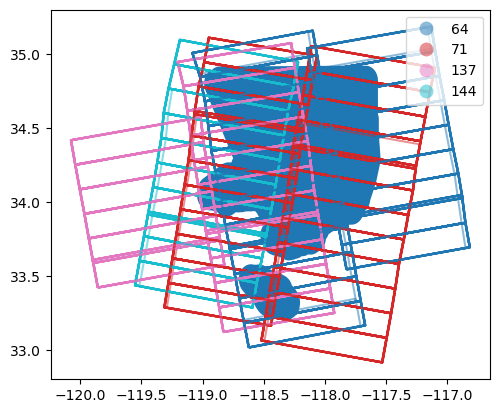

In [23]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax)
df_rtc_resp_plot = df_rtc_resp.copy()
df_rtc_resp_plot.geometry = df_rtc_resp_plot.geometry.boundary
df_rtc_resp_plot.plot(ax=ax, alpha=.5, column='pathNumber', categorical=True, legend=True)

## Select Path

In [24]:
TRACK_NUMBER = 64

In [25]:
df_rtc_track = df_rtc_resp[df_rtc_resp.pathNumber== TRACK_NUMBER].reset_index(drop=True)
df_rtc_track.acq_date.unique()

array([datetime.date(2025, 1, 21), datetime.date(2025, 1, 9),
       datetime.date(2024, 12, 28), datetime.date(2024, 12, 16),
       datetime.date(2024, 12, 4), datetime.date(2024, 11, 22),
       datetime.date(2024, 11, 10), datetime.date(2024, 10, 29),
       datetime.date(2024, 10, 17), datetime.date(2024, 10, 5),
       datetime.date(2024, 9, 23), datetime.date(2024, 9, 11),
       datetime.date(2024, 8, 30), datetime.date(2024, 8, 18),
       datetime.date(2024, 8, 6), datetime.date(2024, 7, 25),
       datetime.date(2024, 7, 13)], dtype=object)

In [26]:
(df_rtc_track.acq_dt > pd.to_datetime(EVENT_DATE, utc=True)).sum()

42

In [27]:
def get_url_tif(row: pd.Series, polarization='vh') -> str:
    if polarization not in ['vv', 'vh']:
        raise ValueError('polarization not specified correctly')
    urls = [row.url] + row.additionalUrls
    pol_token = '_VH.tif' if polarization=='vh' else '_VV.tif'
    valid_urls = [url for url in urls if pol_token in url]
    if not valid_urls:
        raise ValueError('No urls found')
    tif_url = valid_urls[0]
    return tif_url

In [28]:
get_url_tif_vv = lambda row: get_url_tif(row, polarization='vv')
df_rtc_track['vh_url'] = df_rtc_track.apply(get_url_tif, axis=1)
df_rtc_track['vv_url'] = df_rtc_track.apply(get_url_tif_vv, axis=1)
df_rtc_track['burst_id'] = df_rtc_track.fileID.map(lambda file_id: file_id.split('_')[3])
df_rtc_track['vh_url'].tolist()[0], df_rtc_track['vv_url'].tolist()[0]

('https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VH.tif',
 'https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VV.tif')

# Download RTCs by Burst

`out/<AOI_NAME>/rtc_ts/<burst_id>/<tif_files>`

In [29]:
rtc_ts_dir = out_dir / 'rtc_ts' / f'track{TRACK_NUMBER}'
rtc_ts_dir.mkdir(exist_ok=True, parents=True)

In [30]:

@backoff.on_exception(
    backoff.expo,
    [ConnectionError, HTTPError, RasterioIOError],
    max_tries=10,
    max_time=60,
    jitter=backoff.full_jitter,
)
def localize_one_rtc(
    url: str,
    ts_dir: str | Path
) -> Path:
    local_fn = url.split("/")[-1]
    out_path = ts_dir / local_fn
    if not ts_dir.exists():
        ts_dir.mkdir(parents=True)
    if out_path.exists():
        return out_path
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=16384): 
                f.write(chunk)
    return out_path

In [31]:
burst_ids = df_rtc_track.burst_id.tolist()
vv_urls = df_rtc_track.vv_url.tolist()
vh_urls = df_rtc_track.vh_url.tolist()

In [32]:
zipped_inputs = [[url, rtc_ts_dir/ burst_id] for (url, burst_id) in zip(vv_urls + vh_urls, burst_ids * 2)]
zipped_inputs[0]

['https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VV.tif',
 PosixPath('out/los-angeles-fire/rtc_ts/track64/T064-135525-IW1')]

In [33]:
def localize_one_rtc_p(data: tuple) -> Path:
    return localize_one_rtc(*data)

In [34]:
import concurrent.futures

# localize_one_rtc(*zipped_inputs[0])
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths_rtc = list(tqdm(executor.map(localize_one_rtc_p, zipped_inputs[:]), total=len(zipped_inputs)))

  0%|          | 0/714 [00:00<?, ?it/s]

# Despeckle

In [35]:
from distmetrics import despeckle_rtc_arrs_with_tv

In [36]:
rtc_ts_dir

PosixPath('out/los-angeles-fire/rtc_ts/track64')

In [37]:
tv_dir = rtc_ts_dir.parents[1] / 'rtc_ts_tv' / f'track{TRACK_NUMBER}'
tv_dir.mkdir(exist_ok=True, parents=True)
tv_dir

PosixPath('out/los-angeles-fire/rtc_ts_tv/track64')

In [38]:
burst_ids = [p.parent.stem for p in out_paths_rtc]
burst_ids[:3]

['T064-135525-IW1', 'T064-135524-IW2', 'T064-135524-IW1']

In [39]:
out_paths_rtc_d = [tv_dir / burst_id / p.name for (burst_id, p) in zip(burst_ids, out_paths_rtc)]
out_paths_rtc_d[:3]

[PosixPath('out/los-angeles-fire/rtc_ts_tv/track64/T064-135525-IW1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VV.tif'),
 PosixPath('out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW2/OPERA_L2_RTC-S1_T064-135524-IW2_20250121T015056Z_20250121T085633Z_S1A_30_v1.0_VV.tif'),
 PosixPath('out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20250121T015055Z_20250123T190010Z_S1A_30_v1.0_VV.tif')]

In [40]:
def open_one(path: Path):
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p

def serialize_one(arr:np.ndarray, p: dict, out_path: Path):
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(arr, 1)
    return out_path

def despeckle_and_serialize(rtc_paths: list[Path],
                            dst_paths: list[Path],
                            batch_size=100) -> list:
    # Ensure new directories exist
    [p.parent.mkdir(exist_ok=True, parents=True) for p in dst_paths]
    # one liner for math.ceil
    n_batches = (len(rtc_paths) + batch_size - 1) // batch_size
    for k in tqdm(range(n_batches), desc='batch'):
        paths_subset = rtc_paths[k * batch_size: (k + 1) * batch_size]
        dst_paths_subset = dst_paths[k * batch_size: (k + 1) * batch_size]

        # don't overwrite
        dst_paths_subset = [dst_p for dst_p in dst_paths_subset if not dst_p.exists()]
        paths_subset = [src_p for (src_p, dst_p) in zip(paths_subset, dst_paths_subset) if not dst_p.exists()]
        
        # open
        if dst_paths_subset:
            arrs, ps = zip(*list(map(open_one, paths_subset)))
            # despeckle
            arrs_d = despeckle_rtc_arrs_with_tv(arrs)
            # serialize
            [serialize_one(arr, prof, dst_path) for (arr, prof, dst_path) in zip(arrs_d, ps, dst_paths_subset)]

    return dst_paths

In [41]:
out_paths_rtc_d = despeckle_and_serialize(out_paths_rtc, out_paths_rtc_d, batch_size=100)

batch:   0%|          | 0/8 [00:00<?, ?it/s]

In [42]:
out_paths_rtc_d[0].stem

'OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VV'

# Generate Disturbance Map - by Burst

# Create LUT by burst to paths

In [43]:
vv_path_data = [{'burst_id': p.parent.stem, 
                 'vv_path': str(p),
                 'acq_timestamp': pd.to_datetime(p.stem.split('_')[4])} for p in out_paths_rtc_d if 'VV.tif' in p.name]
vv_path_data[:3]

[{'burst_id': 'T064-135525-IW1',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135525-IW1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:57+0000', tz='UTC')},
 {'burst_id': 'T064-135524-IW2',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW2/OPERA_L2_RTC-S1_T064-135524-IW2_20250121T015056Z_20250121T085633Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:56+0000', tz='UTC')},
 {'burst_id': 'T064-135524-IW1',
  'vv_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20250121T015055Z_20250123T190010Z_S1A_30_v1.0_VV.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:55+0000', tz='UTC')}]

In [44]:
vh_path_data = [{'burst_id': p.parent.stem, 
                 'vh_path': str(p),
                 'acq_timestamp': pd.to_datetime(p.stem.split('_')[4])} for p in out_paths_rtc_d if 'VH.tif' in p.name]
vh_path_data[:3]

[{'burst_id': 'T064-135525-IW1',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135525-IW1/OPERA_L2_RTC-S1_T064-135525-IW1_20250121T015057Z_20250121T085633Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:57+0000', tz='UTC')},
 {'burst_id': 'T064-135524-IW2',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW2/OPERA_L2_RTC-S1_T064-135524-IW2_20250121T015056Z_20250121T085633Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:56+0000', tz='UTC')},
 {'burst_id': 'T064-135524-IW1',
  'vh_path': 'out/los-angeles-fire/rtc_ts_tv/track64/T064-135524-IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20250121T015055Z_20250123T190010Z_S1A_30_v1.0_VH.tif',
  'acq_timestamp': Timestamp('2025-01-21 01:50:55+0000', tz='UTC')}]

In [45]:
len(vh_path_data) == df_rtc_track.shape[0]

True

In [46]:
df_vv = pd.DataFrame(vv_path_data)
df_vh = pd.DataFrame(vh_path_data)

df_vv['date_str'] = df_vv.acq_timestamp.dt.date.astype(str)
df_vh['date_str'] = df_vh.acq_timestamp.dt.date.astype(str)
df_loc_ts = pd.merge(df_vv, df_vh[['burst_id', 'date_str', 'vh_path']], on=['burst_id', 'date_str'], how='inner')
df_loc_ts = df_loc_ts[['burst_id', 'acq_timestamp', 'date_str', 'vv_path', 'vh_path']]
df_loc_ts = df_loc_ts.sort_values(by=['burst_id', 'acq_timestamp']).reset_index(drop=True)
assert df_loc_ts.shape[0] == len(vh_path_data)
df_loc_ts.head()

,burst_id,acq_timestamp,date_str,vv_path,vh_path
0,T064-135514-IW1,2024-07-13 01:50:32+00:00,2024-07-13,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...
1,T064-135514-IW1,2024-07-25 01:50:32+00:00,2024-07-25,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...
2,T064-135514-IW1,2024-08-06 01:50:32+00:00,2024-08-06,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...
3,T064-135514-IW1,2024-08-18 01:50:32+00:00,2024-08-18,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...
4,T064-135514-IW1,2024-08-30 01:50:32+00:00,2024-08-30,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...,out/los-angeles-fire/rtc_ts_tv/track64/T064-13...


## Metric - by Burst

In [154]:
transformer_model = load_transformer_model()

In [155]:
burst_ids_unique = df_loc_ts.burst_id.unique().tolist()
len(burst_ids_unique)

21

In [156]:
def open_one_arr(path: Path):
    with rasterio.open(path) as ds:
        X = ds.read(1)

    return X

def compute_distmetric(burst_id: str, 
                       post_image_proximity_to_event: str = 'closest', 
                       max_pre_images: int = 10,
                       min_pre_images: int = 2) -> np.ndarray:
    assert post_image_proximity_to_event in ['closest', 'farthest'] # or maybe earliest or latest is better

    df_ts = df_loc_ts[df_loc_ts.burst_id == burst_id].reset_index(drop=True)
    df_post = df_ts[df_ts.acq_timestamp >= pd.Timestamp(EVENT_DATE, tz='utc')].reset_index(drop=True)
    df_pre = df_ts[df_ts.acq_timestamp < pd.Timestamp(EVENT_DATE, tz='utc')].reset_index(drop=True)

    pre_vv_paths = df_pre.vv_path[-max_pre_images:].tolist()
    pre_vh_paths = df_pre.vh_path[-max_pre_images:].tolist()

    with rasterio.open(pre_vv_paths[0]) as ds:
        ref_profile = ds.profile

    post_ind = 0 if (post_image_proximity_to_event == 'closest') else -1
    post_vv_path = df_post.vv_path.tolist()[post_ind]
    post_vh_path = df_post.vh_path.tolist()[post_ind]
    post_acq_ts = df_post.acq_timestamp.tolist()[post_ind]
    
    if len(pre_vv_paths) < min_pre_images:
        raise ValueError('Not enough pre-images available')

    pre_arrs_vv = list(map(open_one_arr, pre_vv_paths))
    pre_arrs_vh = list(map(open_one_arr, pre_vh_paths))
    post_vv = open_one_arr(post_vv_path)
    post_vh = open_one_arr(post_vh_path)

    metric_ob = compute_transformer_zscore(transformer_model,
                                        pre_arrs_vv,
                                        pre_arrs_vh,
                                        post_vv,
                                        post_vh,
                                        stride=2, 
                                        batch_size=1024,
                                        memory_strategy='high'
                                        )
    return metric_ob, ref_profile, post_acq_ts

In [157]:
metric_dir = rtc_ts_dir.parents[1] / 'metrics' / f'track{TRACK_NUMBER}'
metric_dir.mkdir(exist_ok=True, parents=True)
metric_dir

PosixPath('out/los-angeles-fire/metrics/track64')

In [158]:
def compute_metric_and_serialize(burst_id: str) -> Path:
    metric_ob, ref_profile, post_ts = compute_distmetric(burst_id)
    burst_metric_dir = metric_dir / burst_id
    burst_metric_dir.mkdir(exist_ok=True, parents=True)
    out_path = burst_metric_dir / f'transformer_{burst_id}_{str(post_ts.date())}.tif'

    dist = metric_ob.dist
    with rasterio.open(out_path, 'w', **ref_profile) as ds:
        ds.write(dist, 1)
    return out_path

In [159]:
metric_paths = list(map(compute_metric_and_serialize, tqdm(burst_ids_unique, desc='burst_id')))

burst_id:   0%|          | 0/21 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1251 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1249 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1249 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1284 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1248 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1282 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1248 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1280 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1246 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1279 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1244 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1278 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1244 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1276 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1242 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1276 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1241 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1275 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1241 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1273 [00:00<?, ?it/s]

Chips Traversed:   0%|                                   | 0/1240 [00:00<?, ?it/s]

### Merge and Serialize

In [160]:
def open_one(path: Path) -> tuple[np.ndarray, dict]:
    with rasterio.open(path) as ds:
        arr = ds.read(1)
        p = ds.profile
    return arr, p

In [166]:
data = list(map(open_one, metric_paths))
metric_arrs, metric_profs = zip(*data)

In [172]:
from distmetrics.rio_tools import merge_with_weighted_overlap, most_common_crs, generate_dilated_exterior_nodata_mask, get_distance_from_mask

In [173]:
%%time

X_metric_m, p_metric_m = merge_with_weighted_overlap(metric_arrs, metric_profs, exterior_mask_dilation=20)

CPU times: user 13.8 s, sys: 1.89 s, total: 15.7 s
Wall time: 15.7 s


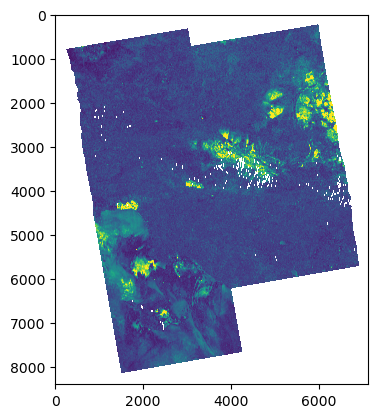

In [174]:
plt.imshow(X_metric_m, vmin=0, vmax=5)

# Water Mask

In [192]:
from rasterio.transform import array_bounds as get_array_bounds
from rasterio.warp import transform_bounds as transform_bounds_into_crs
from rasterio.crs import CRS
from tile_mate import get_raster_from_tiles

height = p_metric_m['height']
width = p_metric_m['width']
transform = p_metric_m['transform']
metric_bounds_utm = get_array_bounds(height, width, transform)
metric_bounds_utm

(304140.0, 3648630.0, 517590.0, 3900750.0)

In [193]:
metric_bounds_4326 = transform_bounds_into_crs(p_metric_m['crs'], CRS.from_epsg(4326),*metric_bounds_utm)
metric_bounds_4326

(-119.15225995009473, 32.95845232263299, -116.80664731745985, 35.2498388740419)

In [194]:
X_glad_lc, p_glad_lc  = get_raster_from_tiles(metric_bounds_4326, 
                                              tile_shortname='glad_landcover',
                                              year=2020
                                              )

Reading tile imagery: 100%|█████████████████████████| 1/1 [00:11<00:00, 11.18s/it]


For the legend, see this [file](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/legend.xlsx). It is the "legend" found here: https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/download.html

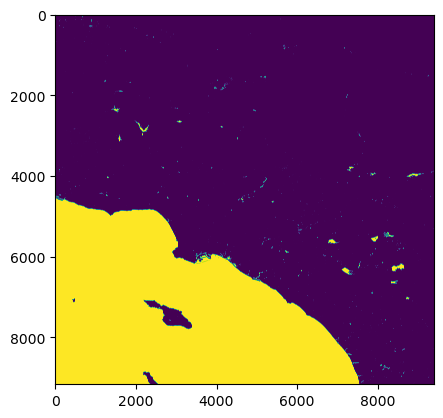

In [219]:
# open water classes
water_labels = [k for k in range(203, 208)] # These are pixels that have surface water at least 50% of the time.
water_labels.extend([254, # ocean
                     255, # no data
                    ])
X_water_glad = np.isin(X_glad_lc[0, ...], water_labels).astype(np.uint8)
plt.imshow(X_water_glad)

In [226]:
X_water_glad_r, p_water_glad = reproject_arr_to_match_profile(X_water_glad, p_glad_lc, p_metric_m, resampling='nearest') 
X_water_glad_r = X_water_glad_r[0, ...]

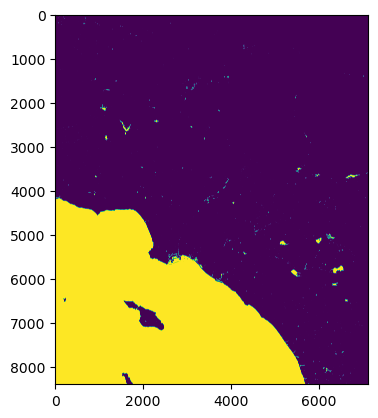

In [228]:
plt.imshow(X_water_glad_r)

In [233]:
X_metric_m_without_water = X_metric_m.copy()

X_metric_m[X_water_glad_r == 1] = np.nan

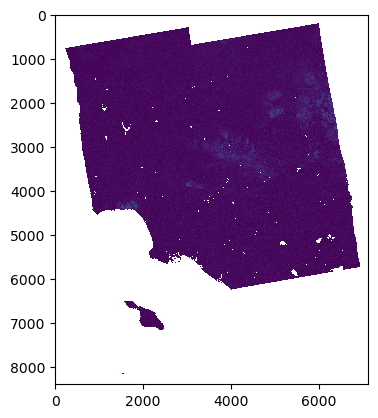

In [234]:
plt.imshow(X_metric_m_without_water, interpolation='none')

# Serialized Masked Data

In [235]:
p_metric_m['dtype'] = 'float32'
tokens = metric_paths[0].stem.split('_')
track_num_token = tokens[1].split("-")[0]
date_token = tokens[2]
with rasterio.open(metric_dir / f'__merged_{track_num_token}_{tokens[2]}.tif', 'w', **p_metric_m) as ds:
    ds.write(X_metric_m_without_water, 1)

# Generate Disturbance Map

In [236]:
dist_dir = rtc_ts_dir.parents[1] / 'dist_map' / f'track{TRACK_NUMBER}'
dist_dir.mkdir(exist_ok=True, parents=True)
dist_dir

PosixPath('out/los-angeles-fire/dist_map/track64')

In [247]:
X_d = np.zeros(X_metric_m_without_water.shape, dtype=np.uint8)

In [248]:
spatial_mask = np.isnan(X_metric_m_without_water)
X_d[spatial_mask] = 255

# order will matter here
aggressive_range = (X_metric_m_without_water >=2.5)
X_d[aggressive_range] = 1
conservative_range = (X_metric_m_without_water >=4.5)
X_d[conservative_range] = 2

## Nice Colormap

In [249]:
colormap = {
    0: (255, 255, 255, 255),  # white, fully opaque
    1: (255, 204, 204, 255),  # light red, fully opaque
    2: (255, 0, 0, 255),      # red, fully opaque
    255: (0, 0, 0, 0)         # transparent for nodata
}

In [250]:
tokens = metric_paths[0].stem.split('_')
tokens

['transformer', 'T064-135514-IW1', '2025-01-09']

In [251]:
date_token = tokens[-1]

In [253]:
p_dist = p_metric_m.copy()
p_dist['dtype'] = 'uint8'
p_dist['nodata'] = 255

out_dist_path = dist_dir / f'disturbance_track{TRACK_NUMBER}_{date_token}.tif'
with rasterio.open(out_dist_path, 'w', **p_dist) as ds:
    ds.write(X_d, 1)
    ds.write_colormap(1, colormap)

In [254]:
cmap = ListedColormap([np.array(colormap.get(key, (255, 255, 255, 255))) / 255 for key in range(256)])

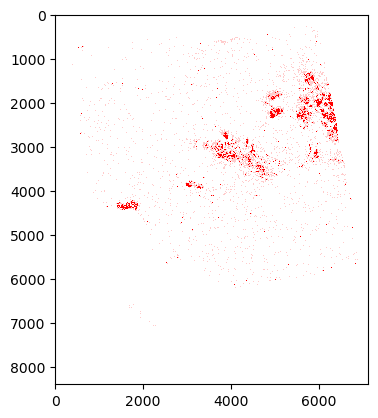

In [256]:
plt.imshow(X_d, cmap=cmap, interpolation='none')